In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys

sys.path.insert(0, "./../")
from FileManager import FileManager
from misc import rcsetup
rcsetup()

In [2]:
def get_color(x, cmap='hsv'):
    return plt.colormaps[cmap](x)

def darken_color(color, amount=0.33):
    amount = float(max(0.0, min(1.0, amount)))
    rgb = mpl.colors.to_rgb(color)
    hsv = mpl.colors.rgb_to_hsv(rgb)
    hsv[2] = max(0.0, hsv[2] * (1.0 - amount))
    return tuple(mpl.colors.hsv_to_rgb(hsv))

In [3]:
class Vocabulary:

    def __init__(self, word_counts):
        self.words = np.array([word for word, c in word_counts])
        self.counts = np.array([c for word, c in word_counts])
        self.word2token = {word:tok for tok, word in enumerate(self.words)}
        self.size = len(self.words)

    def get_count(self, word):
        if word not in self.word2token:
            return 0
        return self.counts[self.word2token.get(word)]

    def to_words(self, tokens):
        return " ".join([self.words[tok] for tok in tokens])

# Prepare word embeddings

In [4]:
VOCAB_SZ = 25_000
data_dir = os.path.join(os.getenv("DATASETPATH"), "enwiki", "min200")

data_fm = FileManager(data_dir)
word_counts = data_fm.load("word_counts.pickle")
vocab = Vocabulary(word_counts)

In [5]:
print(f"Computing M*... ", end="")
corpus_stats = data_fm.load("corpus_stats.pickle")
cL = corpus_stats["context_len"]
Cij, Crwij = corpus_stats["counts"], corpus_stats["counts_reweight"]
numcounts = Cij[:VOCAB_SZ, :VOCAB_SZ].sum()
Pij = Crwij[:VOCAB_SZ, :VOCAB_SZ] / (numcounts * (cL + 1)/2)
unigram = vocab.counts[:VOCAB_SZ] / vocab.counts[:VOCAB_SZ].sum()
PiPj = np.outer(unigram, unigram)
Mstar = 2*(Pij - PiPj)/(Pij + PiPj)
print("done.")

Computing M*... 

done.


In [6]:
def get_asym_embeds(M):
    M_gpu = torch.tensor(M, dtype=torch.float32).cuda()
    eigvals, eigvecs = torch.linalg.eigh(M_gpu)
    eigvals = eigvals.cpu().numpy().astype(np.float64)
    eigvecs = eigvecs.cpu().numpy().astype(np.float64)
    del M_gpu
    torch.cuda.empty_cache()
    
    signs = np.sign(eigvals)
    sort_idx = np.argsort(np.abs(eigvals))[::-1]
    eigvals = np.abs(eigvals)[sort_idx]
    signs = signs[sort_idx]
    eigvecs = eigvecs[:, sort_idx]
    embeds = eigvecs * np.sqrt(eigvals[None, :])
    return embeds, signs

embeds, signs = get_asym_embeds(Mstar)

In [ ]:
Mstar_psd = (embeds * (signs[None, :] > 0)) @ embeds.T
Mstar_nsd = (embeds * (signs[None, :] < 0)) @ embeds.T
Mstar_abs = Mstar_psd + Mstar_nsd
assert np.allclose(Mstar, Mstar_psd - Mstar_nsd, atol=1e-2)
gram_matrices = {}
scatters = {}

# Months

In [8]:
month_names = ["january", "february", "march", "april", "may", "june",
               "july", "august", "september", "october", "november", "december"]
month_abbr = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
N = 12
month_nums = np.arange(N)

month_idxs = []
for month in month_names:
  if str(month) not in vocab.word2token:
    print(month)
    continue
  month_idxs.append(vocab.word2token[month])
month_idxs = np.array(month_idxs)

month_colors = np.array(get_color(1 - np.arange(12)/12.0, cmap='hsv'))
month_colors = np.roll(month_colors, 7, axis=0)

## Co-occurrence statistics

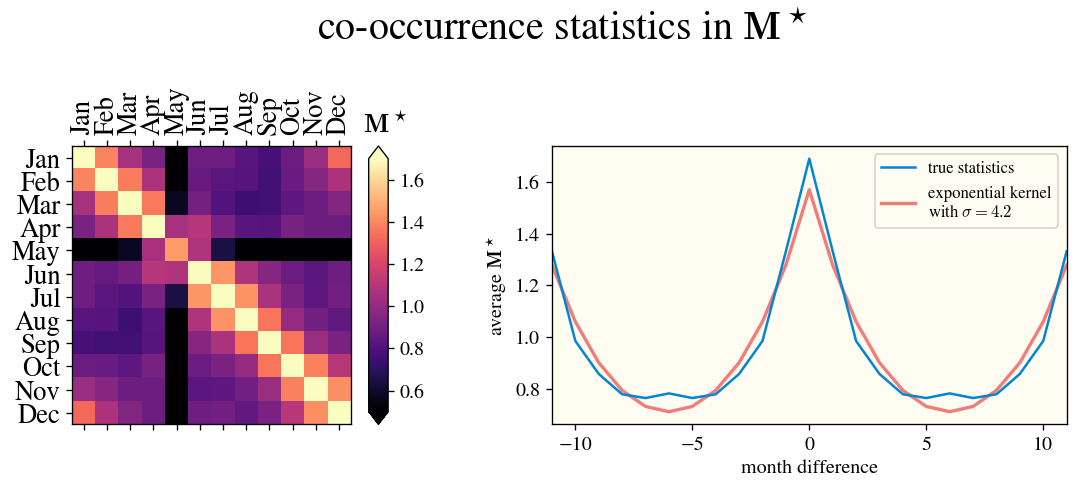

In [9]:
do_plot = "mstar"
if do_plot == "mstar":
    Mplot = Mstar
    title = "$\\mathbf{M}^\\star$"
    vmin, vmax = 0.5, 1.7
    width = 4.2
    amp = 1.4
elif do_plot == "mstar_psd":
    Mplot = Mstar_psd
    title = "$\\mathbf{M}^+$"
    vmin, vmax = 2, 8 
    width = 6.3
    amp = 5
elif do_plot == "mstar_nsd":
    Mplot = Mstar_nsd
    title = "$\\mathbf{M}^-$"
    vmin, vmax = 2, 8
    width = 6
    amp = 4.4
elif do_plot == "mstar_abs":
    Mplot = Mstar_abs
    title = "$|\\mathbf{M}^\\star|$"
    vmin, vmax = 7, 15
    width = 6.8
    amp = 8.5

Mplot_submatrix = Mplot[np.ix_(month_idxs, month_idxs)].copy()

EXP_KERNEL = lambda x: amp * np.exp(-np.abs(x) / width)
FUNCTIONAL_FORM = lambda x: np.sum([EXP_KERNEL(x-n*N) for n in [-2, -1, 0, 1, 2]], axis=0)

fig, axes = plt.subplots(
    ncols=2,
    figsize=(10, 4),
    width_ratios=[2, 3],
    gridspec_kw=dict(
        left=0.08,
        right=0.92,
        bottom=0.12,
        top=0.7,
        wspace=0.35
    )
)
fig.suptitle(f"co-occurrence statistics in {title}", fontsize=24)

ax = axes[0]
im = ax.matshow(Mplot_submatrix, cmap="magma", aspect='equal',
                vmin=vmin, vmax=vmax)
ax.set_xticks(month_nums)
ax.set_yticks(month_nums)
ax.set_xticklabels(month_abbr, rotation=90, fontsize=16)
ax.set_yticklabels(month_abbr, fontsize=16)
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="7%", pad=0.15)
cbar = fig.colorbar(im, cax=cax, extend='both')
cax.set_title("  " +title, pad=8, fontsize=16)

ax = axes[1]
envelope = np.zeros(2*N-1)
for i in range(N):        
    diag = np.diag(Mplot_submatrix, k=i)
    if i != 0:
        diag2 = np.diag(Mplot_submatrix, k=i-N)
        diag = np.concatenate([diag, diag2])
    val = np.mean(diag)
    envelope[N-1 + i] = val
    envelope[N-1 - i] = val

xx = np.arange(-N+1, N)
ax.plot(xx, envelope, color="xkcd:cerulean", label="true statistics")
ax.plot(xx, FUNCTIONAL_FORM(np.minimum(np.abs(xx), 12-np.abs(xx))),
        color="xkcd:red", alpha=0.5, lw=2, zorder=-4, label=f"exponential kernel\nwith $\\sigma={width}$")
ax.axvline(-82, color="k", ls="--", lw=1, alpha=0.3)
ax.axvline(82, color="k", ls="--", lw=1, alpha=0.3)
ax.set_xlabel("month difference")
ax.set_ylabel(f"average {title}")
ax.set_xlim(-N+1, N-1)
ax.legend(fontsize=10)

plt.show()

## Theory

In [10]:
width = 3.2
amp = 1.3
EXP_KERNEL = lambda x: amp * np.exp(-np.abs(x) / width)
FUNCTIONAL_FORM = lambda x: EXP_KERNEL(x-N) + EXP_KERNEL(x) + EXP_KERNEL(x+N)

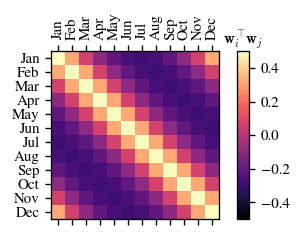

In [11]:
def plot_month_th_gram(fig, M_th, margins):
    left, right, top, bottom = margins
    gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)
    ax = fig.add_subplot(gs[0, 0])
    
    # vmax, vmin = 1.22, 0.1 # uncentered gram
    vmax, vmin = 0.5, -0.5 # centered gram
    im = ax.matshow(M_th, cmap="magma", aspect='equal', vmax=vmax, vmin=vmin)

    ax.set_xticks(month_nums)
    ax.set_yticks(month_nums)
    ax.set_xticklabels(month_abbr, rotation=90, fontsize=9)
    ax.set_yticklabels(month_abbr, fontsize=9)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.15)
    fig.colorbar(im, cax=cax, extend=None)
    cax.set_title(r"$\mathbf{w}_i^\top \!\mathbf{w}_j$", pad=0, fontsize=9)
    cax.tick_params(labelsize=9)
    

dx = month_nums[:, None] - month_nums[None, :]
distances = np.minimum(np.abs(dx), N-np.abs(dx))
M_th = FUNCTIONAL_FORM(distances)
centering = np.eye(N) - np.ones((N, N))/N
M_th = centering @ M_th @ centering.T
gram_matrices['month_th'] = M_th

fig = plt.figure(figsize=(2.5,2))
plot_month_th_gram(fig, gram_matrices['month_th'],
                   margins=(0.2, 0.95, 0.9, 0.2))
plt.show()

In [12]:
d_max = 25_000
W_months = embeds[month_idxs, :d_max]
mu = W_months.mean(axis=0, keepdims=True)
W_months_nomay = np.delete(W_months, 4, axis=0) - mu
_, _, Vt = np.linalg.svd(W_months_nomay, full_matrices=False)

embeds_months = (W_months - mu) @ Vt.T

In [13]:
w = 1 / (width/N)
xx = np.linspace(-1, 1, N, endpoint=False)
W_th = np.zeros((N, 4))
for i in range(4):
    k = np.pi * (i//2 + 1)
    if i % 2 == 0:
        th_curve = np.cos(k*xx - 0.3)
    else:
        th_curve = np.sin(k*xx - 0.3)
    th_curve /= np.linalg.norm(th_curve)
    eigval = amp * 2*w / (w**2 + k**2)
    th_curve *= np.sqrt(eigval)
    W_th[:, i] = th_curve

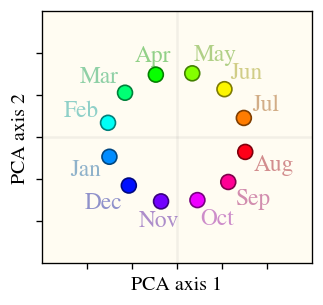

In [14]:
scatter_x = 6 * W_th[:,0]
scatter_y = -6 * W_th[:,1]
scatter_z = -6 * W_th[:,3]
center = (0, 0)

def plot_month_th_embed(fig, scatter_x, scatter_y, margins):
    left, right, top, bottom = margins
    gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)
    ax = fig.add_subplot(gs[0, 0])

    ax.scatter(scatter_x, scatter_y,
            c=month_colors, s=80,
            edgecolors=[darken_color(c, amount=0.5) for c in month_colors])

    eps = 0.2
    for i, month in enumerate(month_abbr):
        x, y = scatter_x[i], scatter_y[i]
        theta = np.arctan2(y - center[1], x - center[0])
        def align(x, neg, pos, eps=0.01):
            return pos if x > eps else neg if x < -eps else 'center'
        ha = align(np.cos(theta), 'right', 'left')
        va = align(np.sin(theta), 'top', 'bottom')
        color = darken_color(month_colors[i], amount=0.4)
        if month == "Apr":
            ha = 'center'
        if month == "Nov":
            ha = 'center'
        ax.annotate(
            month, (x + eps*np.cos(theta), y + eps*np.sin(theta)),
            ha=ha, va=va, alpha=0.44, fontsize=14, color=color
        )

    ax.axhline(0, color='gray', alpha=0.1)
    ax.axvline(0, color='gray', alpha=0.1)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_yticks([-2, -1, 0, 1, 2])

    ax.tick_params(labelleft=False, labelbottom=False)
    ax.set_xlabel("PCA axis 1", fontsize=12)
    ax.set_ylabel("PCA axis 2", fontsize=12)

fig = plt.figure(figsize=(3, 3))
scatters["month_th"] = (scatter_x, scatter_y)
plot_month_th_embed(fig, *scatters["month_th"], margins=(0.2, 0.95, 0.9, 0.2))
plt.show()


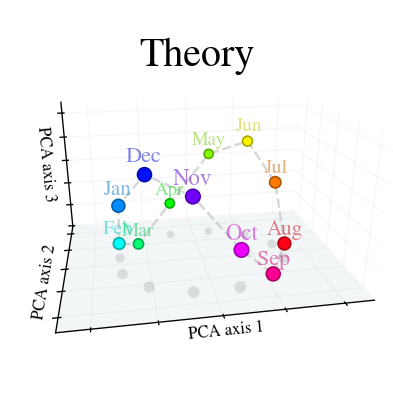

In [15]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

ec = list(map(darken_color, month_colors))
depth = -(scatter_y - scatter_y.max())
ss = 0.5 * (depth + 2) * np.ones(12)

ax.scatter(
    -scatter_x, -scatter_y, scatter_z,
    c=month_colors, edgecolors=ec,
    s=30*ss, alpha=1.0,
)
ax.plot(
    np.r_[-scatter_x, -scatter_x[0]],
    np.r_[-scatter_y, -scatter_y[0]],
    np.r_[scatter_z, scatter_z[0]],
    ls="--", linewidth=1.5, color='xkcd:silver', alpha=0.7,
)

floor_z = np.full(len(scatter_x), scatter_z.min())
ax.scatter(
    -scatter_x, -scatter_y, floor_z,
    c="k", s=20*ss, lw=0, alpha=0.1,
)

for i in month_nums:
    x, y, z = scatter_x[i], scatter_y[i], scatter_z[i]
    color = darken_color(month_colors[i], amount=0.2)
    fs = 0.8*(depth[i] + 14)

    ax.text(-x, -y, z+.3, month_abbr[i],
            ha='center', va='center',
            alpha=0.5, fontsize=fs, zorder=5, c=color)

ax.set_proj_type('persp', focal_length=0.25)
ax.view_init(elev=20, azim=80)

ax.set_facecolor("white")
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.set_facecolor("#e9eeee")

ax.xaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
ax.yaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
ax.zaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlabel("PCA axis 1", labelpad=-15, fontsize=10)
ax.set_ylabel("PCA axis 2", labelpad=-12, fontsize=10)
ax.set_zlabel("PCA axis 3", labelpad=-10, fontsize=10)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim3d(scatter_z.min(), scatter_z.max()+.7)
ax.set_box_aspect((1.3, 1.0, 0.7))
ax.set_title("Theory", fontsize=24, y=0.9)

plt.show()

## Word embeddings

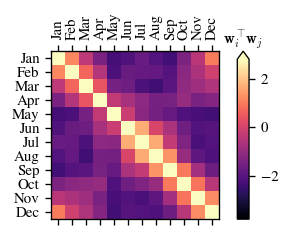

In [16]:
d_max = 25_000
W_months = embeds[month_idxs, :d_max]
W_months_nomay = np.delete(W_months, 4, axis=0)
mu = W_months.mean(axis=0, keepdims=True)
W_months_nomay -= mu
_, _, Vt = np.linalg.svd(W_months_nomay, full_matrices=False)

embeds_months = (W_months - mu) @ Vt.T

gram = embeds_months @ embeds_months.T

def plot_month_w2v_gram(fig, gram, margins):
    left, right, top, bottom = margins
    gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)
    ax = fig.add_subplot(gs[0, 0])

    # vmin, vmax = 6.3, 13.8 # uncentered gram
    vmin, vmax = -3.8, 2.8
    im = ax.matshow(gram, cmap="magma", aspect='equal', vmax=vmax, vmin=vmin)
    ax.set_xticks(np.arange(12))
    ax.set_yticks(np.arange(12))
    ax.set_xticklabels(month_abbr, rotation=90, fontsize=9)
    ax.set_yticklabels(month_abbr, fontsize=9)
    ax.set_aspect('equal')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.15)
    fig.colorbar(im, cax=cax, extend='max')
    cax.set_title(r"$\mathbf{w}_i^\top \!\mathbf{w}_j$", pad=0, fontsize=9)
    cax.tick_params(labelsize=9)

fig = plt.figure(figsize=(2.5, 2))
gram_matrices['month_w2v'] = gram
plot_month_w2v_gram(fig, gram, margins=(0.2, 0.95, 0.9, 0.2))
plt.show()

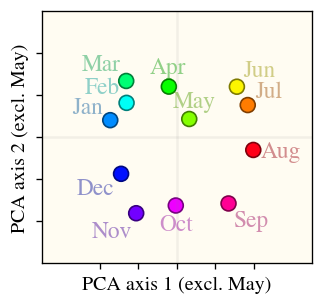

In [17]:
def plot_month_w2v_embed(fig, scatter_x, scatter_y, margins):
    left, right, top, bottom = margins
    gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)
    ax = fig.add_subplot(gs[0, 0])

    ax.scatter(scatter_x, scatter_y,
            c=month_colors, s=80,
            edgecolors=[darken_color(c, amount=0.5) for c in month_colors])

    eps = 0.2
    for i, month in enumerate(month_abbr):
        x, y = scatter_x[i], scatter_y[i]
        theta = np.arctan2(y - scatter_y.mean(), x - scatter_x.mean())
        def align(x, neg, pos, eps=0.16):
            return pos if x > eps else neg if x < -eps else 'center'
        ha = align(np.cos(theta), 'right', 'left')
        va = align(np.sin(theta), 'top', 'bottom')
        color = darken_color(month_colors[i], amount=0.4)
        if month == "Apr":
            ha = 'center'
        if month == "May":
            ha = 'center'
        ax.annotate(
            month, (x + eps*np.cos(theta), y + eps*np.sin(theta)),
            ha=ha, va=va, alpha=0.44, fontsize=14, c=color
        )

    ax.axhline(0, color='gray', alpha=0.1)
    ax.axvline(0, color='gray', alpha=0.1)
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3, 3)
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.tick_params(labelleft=False, labelbottom=False)
    ax.set_xlabel("PCA axis 1 (excl. May)", fontsize=12)
    ax.set_ylabel("PCA axis 2 (excl. May)", fontsize=12)

scatter_x = embeds_months[:,0]
scatter_y = -embeds_months[:,1]
scatter_z = embeds_months[:,2]
fig = plt.figure(figsize=(3, 3))
scatters["month_w2v"] = (scatter_x, scatter_y)
plot_month_w2v_embed(fig, *scatters["month_w2v"], margins=(0.2, 0.95, 0.9, 0.2))
plt.show()

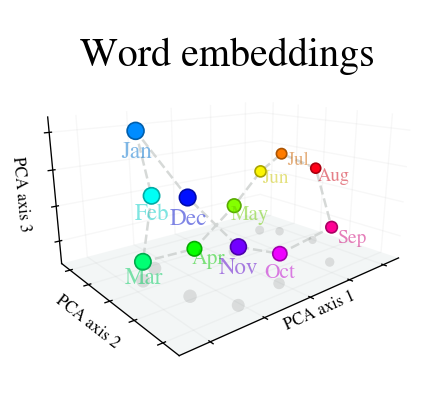

In [18]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

ec = list(map(darken_color, month_colors))
depth = -(scatter_x - scatter_x.max())
ss = 0.6 * (depth + 2) * np.ones(12)

ax.scatter(
    -scatter_x, -scatter_y, scatter_z,
    c=month_colors, edgecolors=ec,
    s=30*ss, alpha=1.0,
)
ax.plot(
    np.r_[-scatter_x, -scatter_x[0]],
    np.r_[-scatter_y, -scatter_y[0]],
    np.r_[scatter_z, scatter_z[0]],
    ls="--", linewidth=1.5, color='xkcd:silver', alpha=0.7,
)

floor_z = np.full(len(scatter_x), scatter_z.min())
ax.scatter(
    -scatter_x, -scatter_y, floor_z,
    c="k", s=20*ss, lw=0, alpha=0.1,
)

for i in month_nums:
    x, y, z = scatter_x[i], scatter_y[i], scatter_z[i]
    color = darken_color(month_colors[i], amount=0.2)
    fs = 0.8*(depth[i] + 14)
    if i in [0, 1, 2, 9, 10, 11]:
        y += 0.6
        z -= 0.4
    ax.text(-x, -y+0.6, z-0.1, month_abbr[i],
            ha='center', va='center',
            alpha=0.5, fontsize=fs, zorder=5, c=color)

ax.set_proj_type('persp', focal_length=0.25)
ax.view_init(elev=15, azim=50)

ax.set_facecolor("white")
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.set_facecolor("#e9eeee")

ax.xaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
ax.yaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
ax.zaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlabel("PCA axis 1", labelpad=-15, fontsize=10)
ax.set_ylabel("PCA axis 2", labelpad=-12, fontsize=10)
ax.set_zlabel("PCA axis 3", labelpad=-10, fontsize=10)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim3d(scatter_z.min(), scatter_z.max()+.2)
ax.set_box_aspect((1.3, 1.0, 0.7))
ax.set_title("Word embeddings", fontsize=24, y=0.9)

plt.show()

## Gemma 2 2B

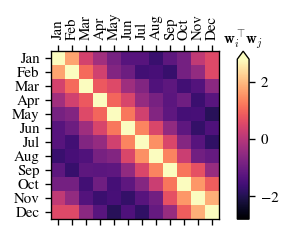

In [19]:
data = np.load("lm_reps/gemma2b_months_contextualized.npy", allow_pickle=True).tolist()
layer = "layer_4"
reps = []
for prompt, rep in data[layer].items():
    reps.append(rep)
W_gemma = np.array(reps)

mu = W_gemma.mean(axis=0, keepdims=True)
_, _, Vt = np.linalg.svd(W_gemma - mu, full_matrices=False)
W_gemma = (W_gemma - mu) @ Vt.T
W_gemma /= 20
gram = W_gemma @ W_gemma.T

def plot_month_gemma_gram(fig, gram, margins):
    left, right, top, bottom = margins
    gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)
    ax = fig.add_subplot(gs[0, 0])

    # vmin, vmax = 21.0, 29.1 # uncentered gram
    vmin, vmax = -2.8, 2.8 # centered gram
    im = ax.matshow(gram, cmap="magma", aspect='equal', vmax=vmax, vmin=vmin)
    ax.set_xticks(np.arange(12))
    ax.set_yticks(np.arange(12))
    ax.set_xticklabels(month_abbr, rotation=90, fontsize=9)
    ax.set_yticklabels(month_abbr, fontsize=9)
    ax.set_aspect('equal')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.15)
    fig.colorbar(im, cax=cax, extend='max')
    cax.set_title(r"$\mathbf{w}_i^\top \!\mathbf{w}_j$", pad=0, fontsize=9)
    cax.tick_params(labelsize=9)

fig = plt.figure(figsize=(2.5, 2))
gram_matrices['month_gemma'] = gram
plot_month_gemma_gram(fig, gram, margins=(0.2, 0.95, 0.9, 0.2))
plt.show()

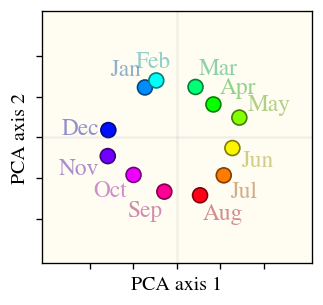

In [20]:
def plot_month_gemma_embed(fig, scatter_x, scatter_y, margins):
    left, right, top, bottom = margins
    gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)
    ax = fig.add_subplot(gs[0, 0])

    ax.scatter(scatter_x, scatter_y,
            c=month_colors, s=80,
            edgecolors=[darken_color(c, amount=0.5) for c in month_colors])

    eps = 0.2
    for i, month in enumerate(month_abbr):
        x, y = scatter_x[i], scatter_y[i]
        theta = np.arctan2(y - scatter_y.mean(), x - scatter_x.mean())
        def align(x, neg, pos, eps=0.16):
            return pos if x > eps else neg if x < -eps else 'center'
        ha = align(np.cos(theta), 'right', 'left')
        va = align(np.sin(theta), 'top', 'bottom')
        color = darken_color(month_colors[i], amount=0.4)
        if month == "Feb":
            ha = 'center'
        ax.annotate(
            month, (x + eps*np.cos(theta), y + eps*np.sin(theta)),
            ha=ha, va=va, alpha=0.44, fontsize=14, c=color
        )

    ax.axhline(0, color='gray', alpha=0.1)
    ax.axvline(0, color='gray', alpha=0.1)
    ax.set_xlim(-3.1, 3.1)
    ax.set_ylim(-3.1, 3.1)
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.tick_params(labelleft=False, labelbottom=False)
    ax.set_xlabel("PCA axis 1", fontsize=12)
    ax.set_ylabel("PCA axis 2", fontsize=12)

scatter_x = W_gemma[:,0]
scatter_y = W_gemma[:,1]
scatter_z = W_gemma[:,2]
scatters["month_gemma"] = (scatter_x, scatter_y)
fig = plt.figure(figsize=(3, 3))
plot_month_gemma_embed(fig, *scatters["month_gemma"],
                       margins=(0.2, 0.95, 0.9, 0.2))
plt.show()

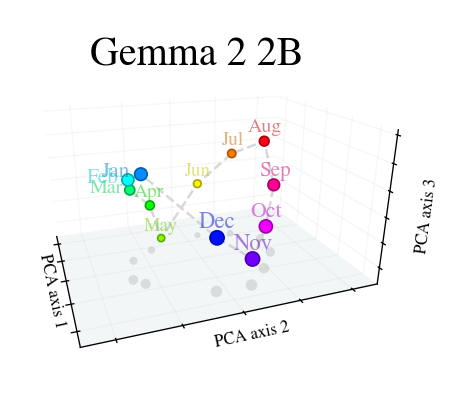

In [21]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

ec = list(map(darken_color, month_colors))
depth = -(scatter_x - scatter_x.max())
ss = 0.6 * (depth + 1) * np.ones(12)

ax.scatter(
    -scatter_x, -scatter_y, scatter_z,
    c=month_colors, edgecolors=ec,
    s=30*ss, alpha=1.0,
)
ax.plot(
    np.r_[-scatter_x, -scatter_x[0]],
    np.r_[-scatter_y, -scatter_y[0]],
    np.r_[scatter_z, scatter_z[0]],
    ls="--", linewidth=1.5, color='xkcd:silver', alpha=0.7,
)

floor_z = np.full(len(scatter_x), scatter_z.min())
ax.scatter(
    -scatter_x, -scatter_y, floor_z,
    c="k", s=20*ss, lw=0, alpha=0.1,
)

for i in month_nums:
    x, y, z = scatter_x[i], scatter_y[i], scatter_z[i]
    color = darken_color(month_colors[i], amount=0.2)
    fs = 0.8*(depth[i] + 14)
    if i in [0, 1, 2]:
        y += 0.4
        z -= 0.2
    ax.text(-x, -y, z+0.3, month_abbr[i],
            ha='center', va='center',
            alpha=0.5, fontsize=fs, zorder=5, c=color)

ax.set_proj_type('persp', focal_length=0.25)
ax.view_init(elev=20, azim=-20)

ax.set_facecolor("white")
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.set_facecolor("#e9eeee")

ax.xaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
ax.yaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
ax.zaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlabel("PCA axis 1", labelpad=-15, fontsize=10)
ax.set_ylabel("PCA axis 2", labelpad=-12, fontsize=10)
ax.set_zlabel("PCA axis 3", labelpad=-10, fontsize=10)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim3d(scatter_z.min(), scatter_z.max()+.7)
ax.set_box_aspect((1.0, 1.3, 0.7))
ax.set_title("Gemma 2 2B", fontsize=24, y=0.9)

plt.show()

# Years

In [22]:
years = np.arange(1700, 2022)

year_idxs = []
for year in years:
  if vocab.word2token[str(year)] >= VOCAB_SZ:
    print(year)
    continue
  year_idxs.append(vocab.word2token[str(year)])
year_idxs = np.array(year_idxs)
N = len(year_idxs)

cc = np.arange(N)
cc = np.linspace(0, 1.2, N)
year_colors = np.array(get_color(cc, cmap='rainbow'))[::-1]

## Co-occurrence statistics

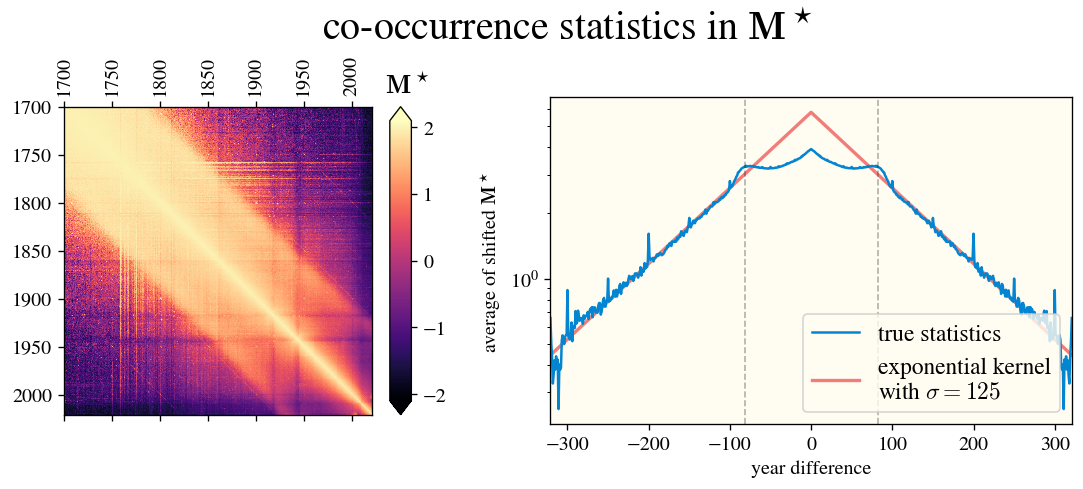

In [23]:
do_plot = "mstar"
if do_plot == "mstar":
    Mplot = Mstar
    title = "$\\mathbf{M}^\\star$"
    vmin, vmax = -2.1, 2.1
    width = 125
    amp = 5.8
elif do_plot == "mstar_psd":
    Mplot = Mstar_psd
    title = "$\\mathbf{M}^+$"
    vmin, vmax = -2, 8 
    width = 115
    amp = 7
elif do_plot == "mstar_nsd":
    Mplot = Mstar_nsd
    title = "$\\mathbf{M}^-$"
    vmin, vmax = -2, 8
    width = 90
    amp = 4.2
elif do_plot == "mstar_abs":
    Mplot = Mstar_abs
    title = "$|\\mathbf{M}^\\star|$"
    vmin, vmax = -2, 15
    width = 120
    amp = 9

Mplot_submatrix = Mplot[np.ix_(year_idxs, year_idxs)].copy()

FUNCTIONAL_FORM = lambda x: amp * np.exp(-np.abs(x) / width)

fig, axes = plt.subplots(
    ncols=2,
    figsize=(10, 4),
    width_ratios=[2, 3],
    gridspec_kw=dict(
        left=0.08,
        right=0.92,
        bottom=0.12,
        top=0.8,
        wspace=0.32
    )
)
fig.suptitle(f"co-occurrence statistics in {title}", fontsize=24)

ax = axes[0]
extent = (years.min(), years.max(),
          years.max(), years.min())
im = ax.matshow(Mplot_submatrix, cmap="magma", aspect='equal', extent=extent,
                vmin=vmin, vmax=vmax)
year_ticks = [y for y in years if y % 50 == 0]
ax.set_xticks(year_ticks)
ax.set_yticks(year_ticks)
ax.set_xticklabels(year_ticks, rotation=90, fontsize=12)
ax.set_yticklabels(year_ticks, fontsize=12)
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="7%", pad=0.15)
cbar = fig.colorbar(im, cax=cax, extend='both')
cax.set_title("  " +title, pad=8, fontsize=16)

ax = axes[1]
envelope = np.zeros(2*N-1)
for i in range(-N+1, N):
    diag = np.diag(Mplot_submatrix, k=i)
    val = np.mean(diag)
    envelope[i+N-1] = val

xx = np.arange(-N+1, N)
ax.plot(xx, envelope - Mplot_submatrix.min(), color="xkcd:cerulean", label="true statistics")
ax.plot(xx, FUNCTIONAL_FORM(xx), color="xkcd:red", alpha=0.5, lw=2, zorder=-4,
        label=f"exponential kernel\nwith $\\sigma={width}$")
ax.axvline(-82, color="k", ls="--", lw=1, alpha=0.3)
ax.axvline(82, color="k", ls="--", lw=1, alpha=0.3)
ax.set_xlabel("year difference")
ax.set_ylabel(f"average of shifted {title}")
ax.set_yscale('log')
ax.set_xlim(-N+1, N-1)
ax.legend(fontsize=14, loc="lower right")

plt.show()

## Theory

In [24]:
width = 125
amp = 5.8
FUNCTIONAL_FORM = lambda x: amp * np.exp(-np.abs(x) / width)

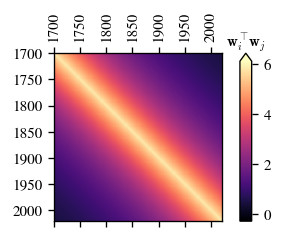

In [25]:
def plot_year_th_gram(fig, M_th, margins):
    left, right, top, bottom = margins
    gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)
    ax = fig.add_subplot(gs[0, 0])
    
    extent = (years.min(), years.max(),
            years.max(), years.min())
    vmin, vmax = -0.3, 6.1 # uncentered gram
    # vmin, vmax = -3, 4 # centered gram
    im = ax.matshow(M_th, cmap="magma", aspect='equal', extent=extent,
                    vmax=vmax, vmin=vmin)

    year_ticks = [y for y in years if y % 50 == 0]
    ax.set_xticks(year_ticks)
    ax.set_yticks(year_ticks)
    ax.set_xticklabels(year_ticks, rotation=90, fontsize=9)
    ax.set_yticklabels(year_ticks, fontsize=9)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.15)
    fig.colorbar(im, cax=cax, extend='max')
    cax.set_title(r"$\mathbf{w}_i^\top \! \mathbf{w}_j$", pad=0, fontsize=9)
    cax.tick_params(labelsize=9)

dx = years[:, None] - years[None, :]
distances = np.abs(dx)
M_th = FUNCTIONAL_FORM(distances)
# centering = np.eye(N) - np.ones((N, N))/N
# M_th = centering @ M_th @ centering
gram_matrices['year_th'] = M_th
fig = plt.figure(figsize=(2.5, 2))
plot_year_th_gram(fig, gram_matrices['year_th'], margins=(0.2, 0.95, 0.9, 0.2))
plt.show()

In [26]:
from scipy.optimize import bisect

def solve_k_sin(sigma, mu):
    f = lambda k: (mu+1)*np.pi/2 - np.arctan2(sigma*k, 1) - k
    return bisect(f, 0, (mu+1)*np.pi, xtol=1e-12)

def solve_k_cos(sigma, mu):
    f = lambda k: mu*np.pi/2 + np.arctan(k/ (1 + sigma*(1+sigma)*(k**2))) - k
    return bisect(f, 0, mu*np.pi, xtol=1e-12)

sigma = 2 * width/N
xx = np.linspace(-1, 1, N)
W_th = np.zeros((N, 8))
flip_axes = [1, 3, 4, 5, 6]
for i in range(8):
    if i % 2 == 0:
        k = solve_k_sin(sigma, i+1)
        th_curve = np.sin(k*xx)
    else:
        k = solve_k_cos(sigma, i+1)
        th_curve = np.cos(k*xx) - np.sin(k) / (k)
    th_curve /= np.sqrt(2/N) * np.linalg.norm(th_curve)
    eigval = amp * 2*sigma / (1 + sigma**2 * k**2)
    W_th[:, i] = np.sqrt(eigval) * th_curve
    if i in flip_axes:
        W_th[:, i] *= -1

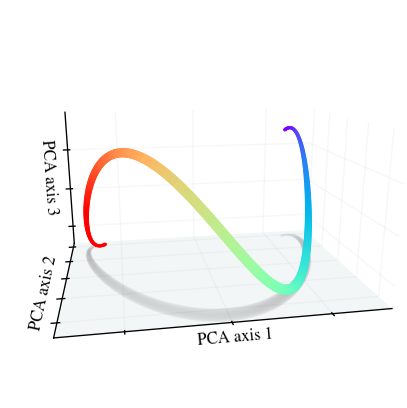

In [27]:
def plot_year_th_embed(fig, scatter_x, scatter_y, scatter_z, margins):
    left, right, top, bottom = margins
    gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)
    ax = fig.add_subplot(gs[0, 0], projection='3d')
    
    ss = 2*(scatter_y - scatter_y.min() + 0.08) * np.ones(len(year_colors))
    ax.scatter(
        scatter_x, scatter_y, scatter_z,
        c=year_colors, s=7*ss, lw=0.9, alpha=1,
    )

    floor_z = np.full(len(scatter_x), scatter_z.min())
    ax.scatter(
        scatter_x, scatter_y, floor_z,
        c="k", s=16*ss, lw=0, alpha=0.02
    )

    ax.set_proj_type('persp', focal_length=0.25)
    ax.view_init(elev=15, azim=80)

    ax.set_facecolor((1, 1, 1, 0))
    ax.patch.set_alpha(0)
    ax.xaxis.pane.set_edgecolor('none')
    ax.yaxis.pane.set_edgecolor('none')
    ax.zaxis.pane.set_edgecolor('none')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.set_facecolor("#e9eeee")

    ax.xaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
    ax.yaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
    ax.zaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    ax.set_xlabel("PCA axis 1", labelpad=-15, fontsize=10)
    ax.set_ylabel("PCA axis 2", labelpad=-12, fontsize=10)
    ax.set_zlabel("PCA axis 3", labelpad=-10, fontsize=10)
    ax.set_zlim3d(scatter_z.min(), scatter_z.min()+1.7)
    ax.set_box_aspect((1.3, 1.0, 0.7))
    

fig = plt.figure(figsize=(5,4))
scatter_x = -W_th[:,0]
scatter_y = -W_th[:,1]
scatter_z = -W_th[:,2]
scatters["year_th"] = (scatter_x, scatter_y, scatter_z)
plot_year_th_embed(fig, scatter_x, scatter_y, scatter_z, margins=(0.15, 0.95, 0.95, 0.15))
plt.show()

## Word embeddings

In [28]:
W_years = embeds[year_idxs, :]
mu = W_years.mean(axis=0, keepdims=True)
_, _, Vt = np.linalg.svd((W_years - mu), full_matrices=False)
embeds_years = (W_years - mu) @ Vt.T

gram = W_years @ W_years.T

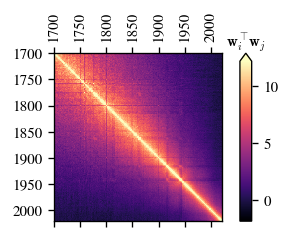

In [29]:
def plot_year_w2v_gram(fig, gram, margins):
    left, right, top, bottom = margins
    gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)
    ax = fig.add_subplot(gs[0, 0])
    extent = (years.min(), years.max(),
            years.max(), years.min())
    
    vmin, vmax = -1.9, 12.2 # uncentered gram
    im = ax.matshow(gram, cmap="magma", aspect='equal',
                    vmax=vmax, vmin=vmin, extent=extent)
    year_ticks = [y for y in years if y % 50 == 0]
    ax.set_xticks(year_ticks)
    ax.set_yticks(year_ticks)
    ax.set_xticklabels(year_ticks, rotation=90, fontsize=9)
    ax.set_yticklabels(year_ticks, fontsize=9)
    ax.set_aspect('equal')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.15)
    fig.colorbar(im, cax=cax, extend='max')
    cax.set_title(r"$\mathbf{w}_i^\top \! \mathbf{w}_j$", pad=0, fontsize=9)
    cax.tick_params(labelsize=9)

fig = plt.figure(figsize=(2.5, 2))
gram_matrices['year_w2v'] = gram
plot_year_w2v_gram(fig, gram_matrices['year_w2v'], margins=(0.2, 0.95, 0.9, 0.2))
plt.show()

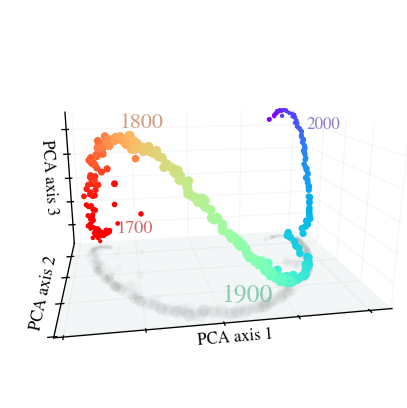

In [30]:
def plot_year_w2v_embed(fig, scatter_x, scatter_y, scatter_z, margins):
    left, right, top, bottom = margins
    gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)
    ax = fig.add_subplot(gs[0, 0], projection='3d')

    ss = (scatter_y - scatter_y.min() + 0.3) * np.ones(len(year_colors))

    ax.scatter(
        scatter_x, scatter_y, scatter_z,
        c=year_colors, s=7*ss, lw=0.9, alpha=1,
    )

    floor_z = scatter_z.min() * np.ones_like(scatter_x)
    ax.scatter(
        scatter_x, scatter_y, floor_z,
        c="k", s=16*ss, lw=0, alpha=0.02
    )

    text_idxs = [0, 100, 200, 300]
    text_locs = np.array([[scatter_x[i], scatter_y[i], scatter_z[i]]
                        for i in text_idxs])
    text_locs += np.array([[0.1, 0.0, -0.3],
                        [-0.1, 0.0, 0.6],
                        [0.3, 0.0, -0.55],
                        [-0.8, 0.0, -0.2],])
    for i, (x, y, z) in enumerate(text_locs):
        yr_idx = text_idxs[i]
        color = darken_color(year_colors[yr_idx], amount=0.3)
        fs = 2*(y - scatter_y.min() + 5)
        ax.text(x, y, z, str(years[yr_idx]),
                ha='center', va='center',
                alpha=0.6, fontsize=fs, zorder=5, c=color)

    ax.set_proj_type('persp', focal_length=0.25)
    ax.view_init(elev=15, azim=80)
    
    ax.set_facecolor((1, 1, 1, 0))
    ax.patch.set_alpha(0)
    ax.xaxis.pane.set_edgecolor('none')
    ax.yaxis.pane.set_edgecolor('none')
    ax.zaxis.pane.set_edgecolor('none')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.set_facecolor("#e9eeee")

    ax.xaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
    ax.yaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
    ax.zaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    ax.set_xlabel("PCA axis 1", labelpad=-15, fontsize=10)
    ax.set_ylabel("PCA axis 2", labelpad=-12, fontsize=10)
    ax.set_zlabel("PCA axis 3", labelpad=-10, fontsize=10)
    ax.set_zlim3d(scatter_z.min(), scatter_z.max())
    ax.set_box_aspect((1.3, 1.0, 0.7))

fig = plt.figure(figsize=(5,4))
scatter_x = -embeds_years[:,0]
scatter_y = -embeds_years[:,1]
scatter_z = -embeds_years[:,2]
scatters["year_w2v"] = (scatter_x, scatter_y, scatter_z)
plot_year_w2v_embed(fig, *scatters["year_w2v"], margins=(0.15, 0.95, 0.95, 0.15))
plt.show()

## Gemma 2 2B

In [31]:
data = np.load("lm_reps/gemma2b_years_contextualized.npy", allow_pickle=True).tolist()
layer = "layer_6"
reps = []
for prompt, rep in data[layer].items():
    if int(prompt.split()[-1]) not in years:
        continue
    reps.append(rep)
W_gemma = np.array(reps)
W_gemma /= 40
gram = W_gemma @ W_gemma.T

mu = W_gemma.mean(axis=0, keepdims=True)
_, _, Vt = np.linalg.svd(W_gemma - mu, full_matrices=False)
W_gemma = (W_gemma - mu) @ Vt.T

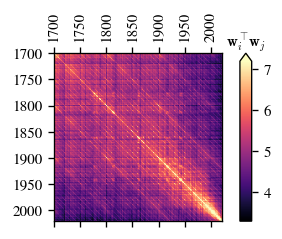

In [32]:
def plot_year_gemma_gram(fig, gram, margins):
    left, right, top, bottom = margins
    gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)
    ax = fig.add_subplot(gs[0, 0])
    
    extent = (years.min(), years.max(),
            years.max(), years.min())
    vmin, vmax = 3.3, 7.2 # uncentered gram
    # vmin, vmax = -3, 4 # centered gram
    im = ax.matshow(gram, cmap="magma", aspect='equal', extent=extent,
                    vmax=vmax, vmin=vmin)

    year_ticks = [y for y in years if y % 50 == 0]
    ax.set_xticks(year_ticks)
    ax.set_yticks(year_ticks)
    ax.set_xticklabels(year_ticks, rotation=90, fontsize=9)
    ax.set_yticklabels(year_ticks, fontsize=9)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.15)
    fig.colorbar(im, cax=cax, extend='max')
    cax.set_title(r"$\mathbf{w}_i^\top \! \mathbf{w}_j$", pad=0, fontsize=9)
    cax.tick_params(labelsize=9)

fig = plt.figure(figsize=(2.5, 2))
gram_matrices['year_gemma'] = gram
plot_year_gemma_gram(fig, gram, margins=(0.2, 0.95, 0.9, 0.2))
plt.show()

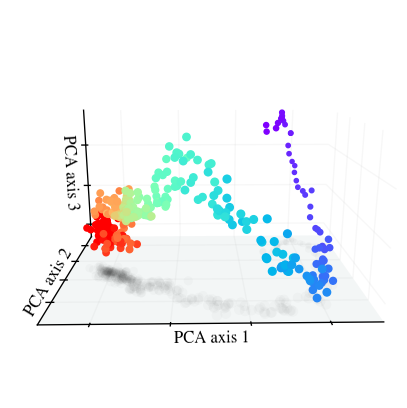

In [33]:
def plot_year_gemma_embed(fig, scatter_x, scatter_y, scatter_z, margins):
    left, right, top, bottom = margins
    gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)
    ax = fig.add_subplot(gs[0, 0], projection='3d')

    ss = (scatter_y - scatter_y.min() + 0.7) * np.ones(len(year_colors))

    ax.scatter(
        scatter_x, scatter_y, scatter_z,
        c=year_colors, s=8*ss, lw=0.9, alpha=1,
    )

    floor_z = scatter_z.min() * np.ones_like(scatter_x)
    ax.scatter(
        scatter_x, scatter_y, floor_z,
        c="k", s=16*ss, lw=0, alpha=0.02
    )

    ax.set_proj_type('persp', focal_length=0.25)
    ax.view_init(elev=15, azim=89)

    ax.set_facecolor((1, 1, 1, 0))
    ax.patch.set_alpha(0)
    ax.xaxis.pane.set_edgecolor('none')
    ax.yaxis.pane.set_edgecolor('none')
    ax.zaxis.pane.set_edgecolor('none')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.set_facecolor("#e9eeee")

    ax.xaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
    ax.yaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
    ax.zaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    ax.set_xlabel("PCA axis 1", labelpad=-15, fontsize=10)
    ax.set_ylabel("PCA axis 2", labelpad=-12, fontsize=10)
    ax.set_zlabel("PCA axis 3", labelpad=-10, fontsize=10)
    ax.set_zlim3d(scatter_z.min(), scatter_z.max()-.01)
    ax.set_box_aspect((1.3, 1.0, 0.7))

scatter_x = -W_gemma[:,0]
scatter_y = -W_gemma[:,1]
scatter_z = -W_gemma[:,2]

fig = plt.figure(figsize=(5,4))
scatters["year_gemma"] = (scatter_x, scatter_y, scatter_z)
plot_year_gemma_embed(fig, *scatters["year_gemma"], margins=(0.15, 0.95, 0.95, 0.15))
plt.show()

# Figure 1

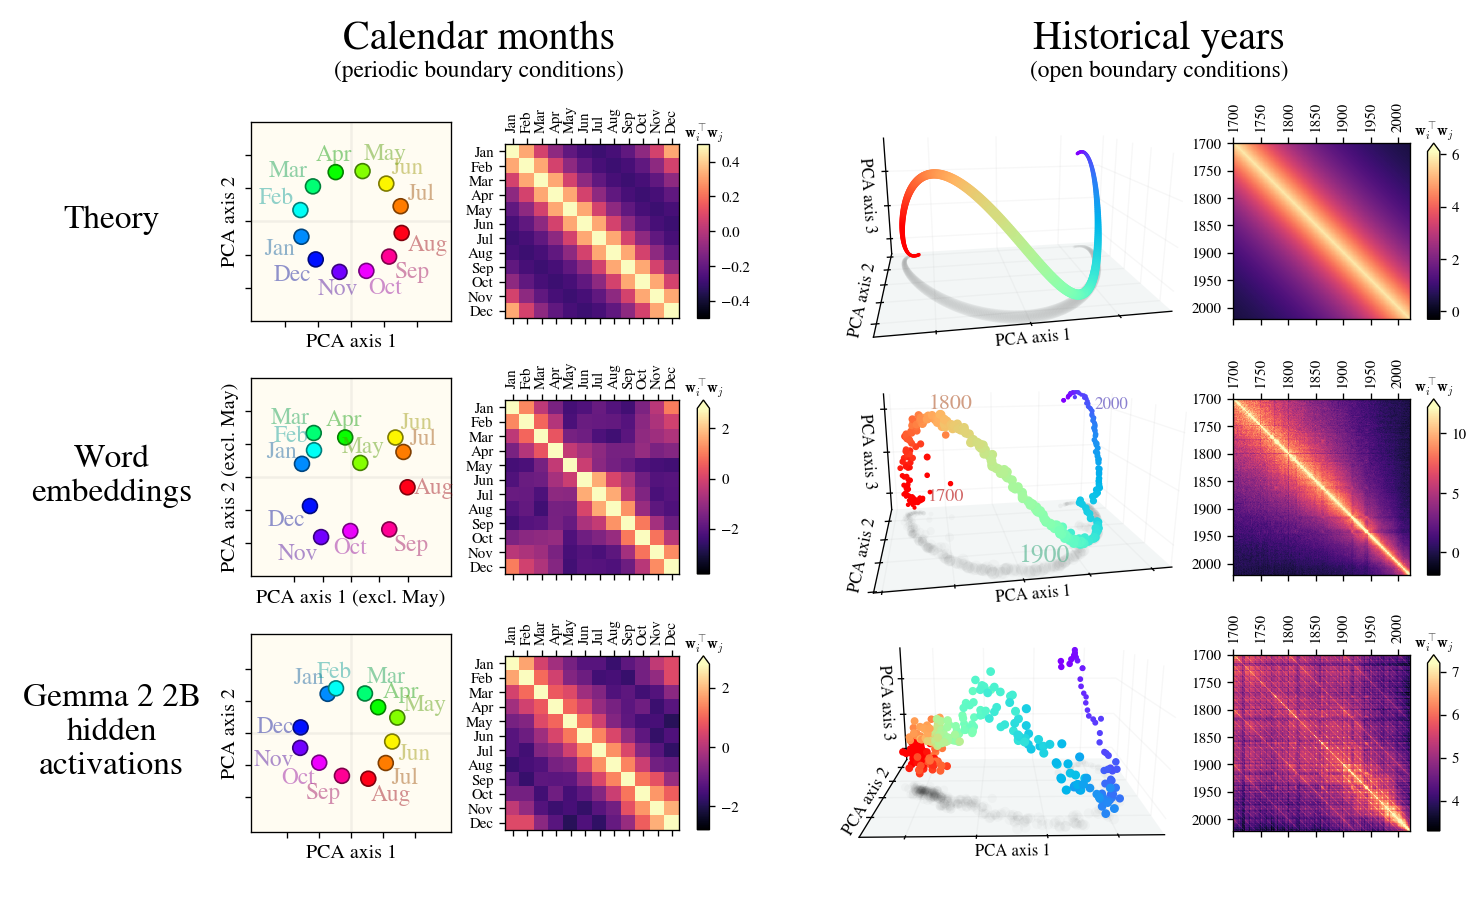

In [34]:
fig = plt.figure(figsize=(12, 7))
subfigs = fig.subfigures(4, 6, width_ratios=[0.8, 1, 1, 0.4, 1.4, 1],
                         height_ratios=[0.3, 1, 1, 1], wspace=0.07, hspace=0.07)

# Outline subfigures to see their bounding boxes
# for sf in subfigs.flat:
#     sf.patch.set_edgecolor('red')
#     sf.patch.set_linewidth(2)
#     sf.patch.set_facecolor('none')

def set_text(subfig, text, x=0.5, y=0.5, **kwargs):
    if not subfig.axes:
        ax = subfig.add_subplot()
    else:
        ax = subfig.axes[0]
    ax.axis('off')
    ax.text(x, y, s=text, **kwargs)

set_text(subfigs[0, 1], "Calendar months",
         x=1.2, y=0.5, fontsize=24, ha="center")
set_text(subfigs[0, 1], "(periodic boundary conditions)",
         x=1.2, y=0, fontsize=14, ha="center")

set_text(subfigs[0, 4], "Historical years",
         x=1, y=0.5, fontsize=24, ha="center")
set_text(subfigs[0, 4], "(open boundary conditions)",
         x=1, y=0, fontsize=14, ha="center")

set_text(subfigs[1, 0], "Theory",
         x=0.5, y=0.5, fontsize=20, ha="center", va="center")
set_text(subfigs[2, 0], "Word\nembeddings",
         x=0.5, y=0.5, fontsize=20, ha="center", va="center")
set_text(subfigs[3, 0], "Gemma 2 2B\nhidden\nactivations",
         x=0.5, y=0.5, fontsize=20, ha="center", va="center")

plot_month_th_embed(subfigs[1, 1], *scatters['month_th'],
                   margins=(0.12, 0.94, 0.9, 0.08))

plot_month_th_gram(subfigs[1, 2], gram_matrices['month_th'],
                   margins=(0.1, 0.94, 0.9, 0.0))

plot_month_w2v_embed(subfigs[2, 1], *scatters['month_w2v'],
                   margins=(0.12, 0.94, 0.9, 0.08))

plot_month_w2v_gram(subfigs[2, 2], gram_matrices['month_w2v'],
                   margins=(0.1, 0.94, 0.9, 0.0))

plot_month_gemma_embed(subfigs[3, 1], *scatters['month_gemma'],
                   margins=(0.12, 0.94, 0.9, 0.08))

plot_month_gemma_gram(subfigs[3, 2], gram_matrices['month_gemma'],
                   margins=(0.1, 0.94, 0.9, 0.0))

plot_year_th_embed(subfigs[1, 4], *scatters['year_th'],
                    margins=(-0.2, 1.1, 1.2, -0.2))

plot_year_th_gram(subfigs[1, 5], gram_matrices['year_th'],
                    margins=(0.1, 0.95, 0.9, 0.0))

plot_year_w2v_embed(subfigs[2, 4], *scatters['year_w2v'],
                    margins=(-0.2, 1.1, 1.2, -0.2))

plot_year_w2v_gram(subfigs[2, 5], gram_matrices['year_w2v'],
                    margins=(0.1, 0.95, 0.9, 0.0))

plot_year_gemma_embed(subfigs[3, 4], *scatters['year_gemma'],
                    margins=(-0.2, 1.1, 1.2, -0.2))

plot_year_gemma_gram(subfigs[3, 5], gram_matrices['year_gemma'],
                    margins=(0.1, 0.95, 0.9, 0.0))

plt.show()
# plt.savefig("plots/fig1.pdf", dpi=300, bbox_inches='tight')